In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# Modeling & Evaluation

In [37]:
targets = 'price'
feature = [col for col in df.columns if col != targets]

b = df[feature]
c = df[targets]

cat_features_price_per_km = b.select_dtypes(include=['object']).columns
num_features_price_per_km = b.select_dtypes(exclude=['object']).columns

print("Categorical features:", cat_features_price_per_km.tolist())
print("Numerical features:", num_features_price_per_km.tolist())

Categorical features: ['brand', 'model_name', 'model_variant', 'car_type', 'transmission', 'fuel_type', 'owner', 'state', 'accidental']
Numerical features: ['year', 'kilometers', 'car_age', 'price_per_km']


In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor to apply different transformations to different columns
preprocessor_price_per_km = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features_price_per_km),
        ('cat', categorical_transformer, cat_features_price_per_km)
    ])

Z_processed = preprocessor_price_per_km.fit_transform(b)

print("Shape of the processed data:", Z_processed.shape)

Shape of the processed data: (105911, 232)


**Split Data**

In [39]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
Z_train, Z_test, c_train, c_test = train_test_split(Z_processed, c, test_size=0.2, random_state=42)

print("Shape of Z_train:", Z_train.shape)
print("Shape of Z_test:", Z_test.shape)
print("Shape of c_train:", c_train.shape)
print("Shape of c_test:", c_test.shape)

Shape of Z_train: (84728, 232)
Shape of Z_test: (21183, 232)
Shape of c_train: (84728,)
Shape of c_test: (21183,)


RandomForestRegressor Model

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train the Random Forest Regressor
rf_model_price_per_km = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_split=2,
    random_state=42
)

rf_model_price_per_km.fit(Z_train, c_train)

# Make predictions on the test set
rf_pred_price_per_km = rf_model_price_per_km.predict(Z_test)

# Evaluate the Random Forest model
r2_rf = r2_score(c_test, rf_pred_price_per_km)
mae_rf = mean_absolute_error(c_test, rf_pred_price_per_km)
rmse_rf = np.sqrt(mean_squared_error(c_test, rf_pred_price_per_km))

print("Random Forest Regressor Evaluation:")
print(f"R² Score: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")

Random Forest Regressor Evaluation:
R² Score: 0.909
MAE: 81962.76
RMSE: 125294.62


XGBoost Model

In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

xgb_model_price_per_km = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model_price_per_km.fit(Z_train, c_train)

# Make predictions on the test set
xgb_pred_price_per_km = xgb_model_price_per_km.predict(Z_test)

# Evaluate the XGBoost model
r2_xgb = r2_score(c_test, xgb_pred_price_per_km)
mae_xgb = mean_absolute_error(c_test, xgb_pred_price_per_km)
rmse_xgb = np.sqrt(mean_squared_error(c_test, xgb_pred_price_per_km))

print("XGBoost Regressor Evaluation:")
print(f"R² Score: {r2_xgb:.3f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")

XGBoost Regressor Evaluation:
R² Score: 0.998
MAE: 8697.26
RMSE: 16356.69


> Observation:
**price_per_km** column is causing the model to predict it is easily by mulitplying it with km, to get the unknown *price* values. So deleting the `price_per_km` column.

In [42]:
df = df.drop("price_per_km", axis=1)
df.head()

,brand,model_name,model_variant,car_type,transmission,fuel_type,year,kilometers,owner,state,accidental,price,car_age
0,Mahindra,TUV300,AX5,SUV,Manual,CNG,2017,164654.0,1st,Rajasthan,No,547253.0,8
1,Skoda,Rapid,Style,Sedan,Manual,Petrol,2018,41351.0,1st,Maharashtra,No,512050.0,7
2,Maruti Suzuki,Alto,Z,Hatchback,Manual,Diesel,2002,119090.0,3rd+,Tamil Nadu,No,678923.0,23
3,Hyundai,Grand i10,Magna,Hatchback,Manual,Diesel,2013,19979.0,1st,Andhra Pradesh,No,522500.0,12
4,Mahindra,XUV500,W8,SUV,Manual,Petrol,2011,130591.0,3rd+,Bihar,No,401182.0,14


> Adding a new column **car_points** as per the below logic.

| **Feature**                   | **Condition / Range**                               | **Points** | **Impact Direction** | **Explanation**                                               |
| ----------------------------- | --------------------------------------------------- | ---------- | -------------------- | ------------------------------------------------------------- |
|**kilometers**                | < 10,000 km                                         | +9         | Positive             | Very low mileage — almost new.                                |
|                               | 10,000–30,000 km                                    | +8         | Positive             | Lightly used; excellent condition.                            |
|                               | 30,000–70,000 km                                    | +6         | Neutral–Positive     | Normal usage for mid-age cars.                                |
|                               | 70,000–100,000 km                                   | +3         | Slightly Negative    | Moderate wear and tear.                                       |
|                               | > 100,000 km                                        | -5         | Negative             | High mileage; price generally drops.                          |
| **car_age**                   | ≤ 2 years                                           | +10        | Positive             | Almost new — minimal depreciation.                            |
|                               | 3–5 years                                           | +8         | Positive             | Good value retention — newer model.                           |
|                               | 6–8 years                                           | +5         | Neutral              | Moderate depreciation expected.                               |
|                               | 9–12 years                                          | +2         | Slightly Negative    | Older; may need maintenance.                                  |
|                               | > 12 years                                          | -4         | Negative             | Significant depreciation.                                     |
| **year (Manufacturing Year)** | Current or Last Year                                | +9         | Positive             | Latest models fetch higher prices.                            |
|                               | 2–5 years old                                       | +7         | Positive             | Recent models still in demand.                                |
|                               | >5 years old                                        | +4         | Neutral              | Older models depreciate faster.                               |
| **model_variant**             | Top / Sports / Limited Edition                      | +10        | Positive             | Premium variant commands higher price.                        |
|                               | Mid Variant                                         | +6         | Positive             | Balanced features and price.                                  |
|                               | Base Variant                                        | +3         | Neutral              | Lower resale value.                                           |
| **model_name**                | Popular & Reliable (e.g., Swift, Corolla)           | +8         | Positive             | High demand improves resale.                                  |
|                               | Moderate Demand                                     | +5         | Neutral              | Average resale potential.                                     |
|                               | Low Demand / Discontinued                           | +2         | Negative             | Low market interest.                                          |
| **state**                     | Metro / High-demand city (Delhi, Mumbai, Bangalore) | +6         | Positive             | Urban demand increases price.                                 |
|                               | Tier-2 / Tier-3 city                                | +3         | Neutral              | Average market activity.                                      |
|                               | Rural / Low-demand region                           | -2         | Negative             | Lower demand affects pricing.                                 |
| **brand**                     | Luxury (BMW, Mercedes, Audi)                        | +10        | Positive             | Strong brand equity and demand.                               |
|                               | Premium (Toyota, Honda, Hyundai)                    | +7         | Positive             | Reliable and trusted.                                         |
|                               | Budget (Tata, Maruti, Renault)                      | +4         | Neutral              | Price-sensitive segment.                                      |
| **car_type**                  | Luxury                                              | +10        | Positive             | Premium comfort and features.                                 |
|                               | SUV                                                 | +8         | Positive             | Popular, high resale value.                                   |
|                               | Sedan                                               | +6         | Positive             | Balanced market demand.                                       |
|                               | MPV                                                 | +5         | Neutral              | Moderate resale depending on usage.                           |
|                               | Hatchback                                           | +4         | Neutral              | Budget-friendly, lower price range.                           |
| **owner**                     | 1st Owner                                           | +8         | Positive             | Best resale value.                                            |
|                               | 2nd Owner                                           | +5         | Neutral              | Acceptable resale if condition is good.                       |
|                               | 3rd or more Owners                                  | +2         | Negative             | Lower trust and resale value.                                 |
| **transmission**              | Automatic                                           | +6         | Positive             | Preferred in urban markets.                                   |
|                               | Manual                                              | +3         | Neutral              | Common and reliable, but cheaper resale.                      |
| **fuel_type**                 | Electric                                            | +8         | Positive             | High initial price, eco-friendly.                             |
|                               | Diesel                                              | +6         | Positive             | Good mileage, higher demand in some regions.                  |
|                               | Petrol                                              | +5         | Neutral              | Standard choice, balanced pricing.                            |
|                               | CNG / LPG                                           | +3         | Slightly Negative    | Economical but lower resale demand.                           |


In [43]:
# Function to calculate points for 'kilometers'
def calculate_kilometers_points(km):
    if km < 10000:
        return 9
    elif 10000 <= km <= 30000:
        return 8
    elif 30000 < km <= 70000:
        return 6
    elif 70000 < km <= 100000:
        return 3
    else:  # km > 100,000 km
        return -5

# Function to calculate points for 'car_age'
def calculate_car_age_points(age):
    if age <= 2:
        return 10
    elif 3 <= age <= 5:
        return 8
    elif 6 <= age <= 8:
        return 5
    elif 9 <= age <= 12:
        return 2
    else:  # age > 12 years
        return -4

# Function to calculate points for 'year' (Manufacturing Year)
import datetime
current_year = datetime.datetime.now().year # Already calculated as 2025 in notebook state

def calculate_year_points(year_val):
    if year_val == current_year:
        return 9
    elif current_year - 4 <= year_val <= current_year - 1: # 2-5 years old: current_year-1 to current_year-4
        return 7
    else: # >5 years old: year < current_year - 4
        return 4

# Function to calculate points for 'brand'
def calculate_brand_points(brand):
    luxury_brands = ['BMW', 'Audi', 'Jaguar', 'Range Rover']
    premium_brands = ['Toyota', 'Honda', 'Hyundai', 'Skoda', 'Volkswagen', 'Ford', 'Nissan', 'Kia', 'MG']
    budget_brands = ['Tata', 'Maruti Suzuki', 'Renault', 'Chevrolet', 'Mahindra']

    if brand in luxury_brands:
        return 10
    elif brand in premium_brands:
        return 7
    elif brand in budget_brands:
        return 4
    else:
        return 0 # Default if brand not found in lists

# Function to calculate points for 'car_type'
def calculate_car_type_points(car_type):
    if car_type == 'Luxury':
        return 10
    elif car_type == 'SUV':
        return 8
    elif car_type == 'Sedan':
        return 6
    elif car_type == 'MPV':
        return 5
    elif car_type == 'Hatchback':
        return 4
    else:
        return 0 # Default

# Function to calculate points for 'owner'
def calculate_owner_points(owner):
    if owner == '1st':
        return 8
    elif owner == '2nd':
        return 5
    elif owner == '3rd+': # Covers 3rd+ and 4th+ (assuming 4th+ is part of 3rd+ category)
        return 2
    else:
        return 0 # Default

# Function to calculate points for 'transmission'
def calculate_transmission_points(transmission):
    if transmission == 'Automatic':
        return 6
    elif transmission == 'Manual':
        return 3
    else:
        return 0 # Default

# Function to calculate points for 'fuel_type'
def calculate_fuel_type_points(fuel_type):
    if fuel_type == 'Electric':
        return 8
    elif fuel_type == 'Diesel':
        return 6
    elif fuel_type == 'Petrol':
        return 5
    elif fuel_type in ['CNG', 'LPG']: # Assuming 'CNG / LPG' means either
        return 3
    else:
        return 0 # Default

# Function to calculate points for 'state'
def calculate_state_points(state):
    metro_states = ['Delhi', 'Maharashtra', 'Karnataka', 'Tamil Nadu', 'Telangana', 'Gujarat', 'West Bengal']
    if state in metro_states:
        return 6
    else:
        return 3 # Default to Tier-2/Tier-3 for simplicity

# Initialize 'car_points' column with zeros
df['car_points'] = 0

# Apply point calculation functions and sum them up
df['car_points'] += df['kilometers'].apply(calculate_kilometers_points)
df['car_points'] += df['car_age'].apply(calculate_car_age_points)
df['car_points'] += df['year'].apply(calculate_year_points)
df['car_points'] += df['brand'].apply(calculate_brand_points)
df['car_points'] += df['car_type'].apply(calculate_car_type_points)
df['car_points'] += df['owner'].apply(calculate_owner_points)
df['car_points'] += df['transmission'].apply(calculate_transmission_points)
df['car_points'] += df['fuel_type'].apply(calculate_fuel_type_points)
df['car_points'] += df['state'].apply(calculate_state_points)

print("New 'car_points' column added to the DataFrame.")
display(df[['brand', 'model_name', 'kilometers', 'car_age', 'year', 'car_type', 'owner', 'transmission', 'fuel_type', 'state', 'car_points']].head())

New 'car_points' column added to the DataFrame.


,brand,model_name,kilometers,car_age,year,car_type,owner,transmission,fuel_type,state,car_points
0,Mahindra,TUV300,164654.0,8,2017,SUV,1st,Manual,CNG,Rajasthan,33
1,Skoda,Rapid,41351.0,7,2018,Sedan,1st,Manual,Petrol,Maharashtra,50
2,Maruti Suzuki,Alto,119090.0,23,2002,Hatchback,3rd+,Manual,Diesel,Tamil Nadu,20
3,Hyundai,Grand i10,19979.0,12,2013,Hatchback,1st,Manual,Diesel,Andhra Pradesh,45
4,Mahindra,XUV500,130591.0,14,2011,SUV,3rd+,Manual,Petrol,Bihar,20


In [ ]:
# Save DataFrame to CSV
df.to_csv("..\\..\\data\\processed\\CleanedCarDataset.csv", index=False)

In [45]:
target = 'price'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

print("Categorical features:", cat_features.tolist())
print("Numerical features:", num_features.tolist())

Categorical features: ['brand', 'model_name', 'model_variant', 'car_type', 'transmission', 'fuel_type', 'owner', 'state', 'accidental']
Numerical features: ['year', 'kilometers', 'car_age', 'car_points']


In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

X_processed = preprocessor.fit_transform(X)

print("Shape of the processed data:", X_processed.shape)

Shape of the processed data: (105911, 232)


**Split Data**

In [47]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (84728, 232)
Shape of X_test: (21183, 232)
Shape of y_train: (84728,)
Shape of y_test: (21183,)


### RandomForest Model

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_split=2,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
r2_rf = r2_score(y_test, rf_pred)
mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest Regressor Evaluation:")
print(f"R² Score: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")

Random Forest Regressor Evaluation:
R² Score: 0.279
MAE: 292100.83
RMSE: 352967.48


### XGBoost Model

In [49]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_pred = xgb_model.predict(X_test)

# Evaluate the XGBoost model
r2_xgb = r2_score(y_test, xgb_pred)
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("XGBoost Regressor Evaluation:")
print(f"R² Score: {r2_xgb:.3f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")

XGBoost Regressor Evaluation:
R² Score: 0.282
MAE: 291104.53
RMSE: 352161.61


### LGBM Model

In [50]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

lgbm_model = lgb.LGBMRegressor(objective='regression', n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=-1)
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
lgbm_pred = lgbm_model.predict(X_test)

# Evaluate the LightGBM model
r2_lgbm = r2_score(y_test, lgbm_pred)
mae_lgbm = mean_absolute_error(y_test, lgbm_pred)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, lgbm_pred))

print("LightGBM Regressor Evaluation:")
print(f"R² Score: {r2_lgbm:.3f}")
print(f"MAE: {mae_lgbm:.2f}")
print(f"RMSE: {rmse_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 84728, number of used features: 232
[LightGBM] [Info] Start training from score 743402.406560


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Regressor Evaluation:
R² Score: 0.279
MAE: 291406.94
RMSE: 352814.32


### AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# AdaBoost with DecisionTree as base estimator
ada_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )

ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

print("\n===== ADA BOOST PERFORMANCE ====")
print("R²:", round(r2_score(y_test, ada_pred),3))
print("MAE:", round(mean_absolute_error(y_test, ada_pred),2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, ada_pred)),2))


===== ADA BOOST PERFORMANCE ====
R²: 0.282
MAE: 291775.91
RMSE: 352148.81


### Linear Regession Model

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_pred = lr_model.predict(X_test)

# Evaluate the Linear Regression model
r2_lr = r2_score(y_test, lr_pred)
mae_lr = mean_absolute_error(y_test, lr_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Linear Regression Model Evaluation:")
print(f"R² Score: {r2_lr:.3f}")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")

Linear Regression Model Evaluation:
R² Score: 0.263
MAE: 294209.25
RMSE: 356687.21


### Decission Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
dt_pred = dt_model.predict(X_test)

# Evaluate the Decision Tree model
r2_dt = r2_score(y_test, dt_pred)
mae_dt = mean_absolute_error(y_test, dt_pred)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_pred))

print("Decision Tree Regressor Evaluation:")
print(f"R² Score: {r2_dt:.3f}")
print(f"MAE: {mae_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")

Decision Tree Regressor Evaluation:
R² Score: -0.440
MAE: 390322.01
RMSE: 498800.46


### Weighted Ensemble Training

In [54]:
#taking the r2 scores from the above models
model_r2_scores = {
    "RandomForest": r2_rf,
    "XGBoost": r2_xgb,
    "LightGBM": r2_lgbm,
    "AdaBoost": 0.29,
    "LinearRegression": r2_lr,
    "DecisionTree": r2_dt
}

# Calculate the sum of all R-squared scores
sum_r2_scores = sum(model_r2_scores.values())

# Calculate weights for each model
weight_rf = model_r2_scores["RandomForest"] / sum_r2_scores
weight_xgb = model_r2_scores["XGBoost"] / sum_r2_scores
weight_lgbm = model_r2_scores["LightGBM"] / sum_r2_scores
weight_ada = model_r2_scores["AdaBoost"] / sum_r2_scores
weight_lr = model_r2_scores["LinearRegression"] / sum_r2_scores
weight_dt = model_r2_scores["DecisionTree"] / sum_r2_scores

print("Model R-squared Scores:", model_r2_scores)
print("Sum of R-squared Scores:", sum_r2_scores)
print("Calculated Weights:")
print(f"  RandomForest Weight: {weight_rf:.3f}")
print(f"  XGBoost Weight: {weight_xgb:.3f}")
print(f"  LightGBM Weight: {weight_lgbm:.3f}")
print(f"  AdaBoost Weight: {weight_ada:.3f}")
print(f"  Linear Regression Weight: {weight_lr:.3f}")
print(f"  DecisionTree Weight: {weight_dt:.3f}")

Model R-squared Scores: {'RandomForest': 0.27873449844702536, 'XGBoost': 0.2820242135270734, 'LightGBM': 0.279360301718778, 'AdaBoost': 0.29, 'LinearRegression': 0.26345232717425004, 'DecisionTree': -0.4403879247006235}
Sum of R-squared Scores: 0.9531834161665034
Calculated Weights:
  RandomForest Weight: 0.292
  XGBoost Weight: 0.296
  LightGBM Weight: 0.293
  AdaBoost Weight: 0.304
  Linear Regression Weight: 0.276
  DecisionTree Weight: -0.462


In [55]:
ensemble_predictions = (
    weight_rf * rf_pred +
    weight_xgb * xgb_pred +
    weight_lgbm * lgbm_pred +
    weight_ada * ada_pred +
    weight_lr * lr_pred +
    weight_dt * dt_pred
)

print("Ensemble predictions calculated.")

Ensemble predictions calculated.


In [56]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2_ensemble = r2_score(y_test, ensemble_predictions)
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

print("Weighted Ensemble Model Evaluation:")
print(f"R² Score: {r2_ensemble:.3f}")
print(f"MAE: {mae_ensemble:.2f}")
print(f"RMSE: {rmse_ensemble:.2f}")

Weighted Ensemble Model Evaluation:
R² Score: 0.128
MAE: 312145.77
RMSE: 388088.19


**Creating different model_performance df**

In [57]:
model_performance = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost', 'LightGBM', 'AdaBoost', 'Linear Regression', 'DecisionTree', 'Weighted Ensemble'],
    'R2 Score': [r2_rf, r2_xgb, r2_lgbm, 0.29, r2_lr, r2_dt, r2_ensemble],
    'MAE': [mae_rf, mae_xgb, mae_lgbm, 288897.92, mae_lr, mae_dt, mae_ensemble],
    'RMSE': [rmse_rf, rmse_xgb, rmse_lgbm, 349401.42, rmse_lr, rmse_dt, rmse_ensemble]
})

model_performance.set_index('Model', inplace=True)
display(model_performance.round(3))

,R2 Score,MAE,RMSE
Model,,,
RandomForest,0.279,292100.832,352967.475
XGBoost,0.282,291104.527,352161.607
LightGBM,0.279,291406.944,352814.316
AdaBoost,0.290,288897.920,349401.420
Linear Regression,0.263,294209.253,356687.212
DecisionTree,-0.440,390322.015,498800.458
Weighted Ensemble,0.128,312145.772,388088.186


In [ ]:
model_performance.to_csv('..\\..\\data\\model_performance.csv', index=True)
print("Model performance data saved to 'model_performance.csv'")

Model performance data saved to 'model_performance.csv'


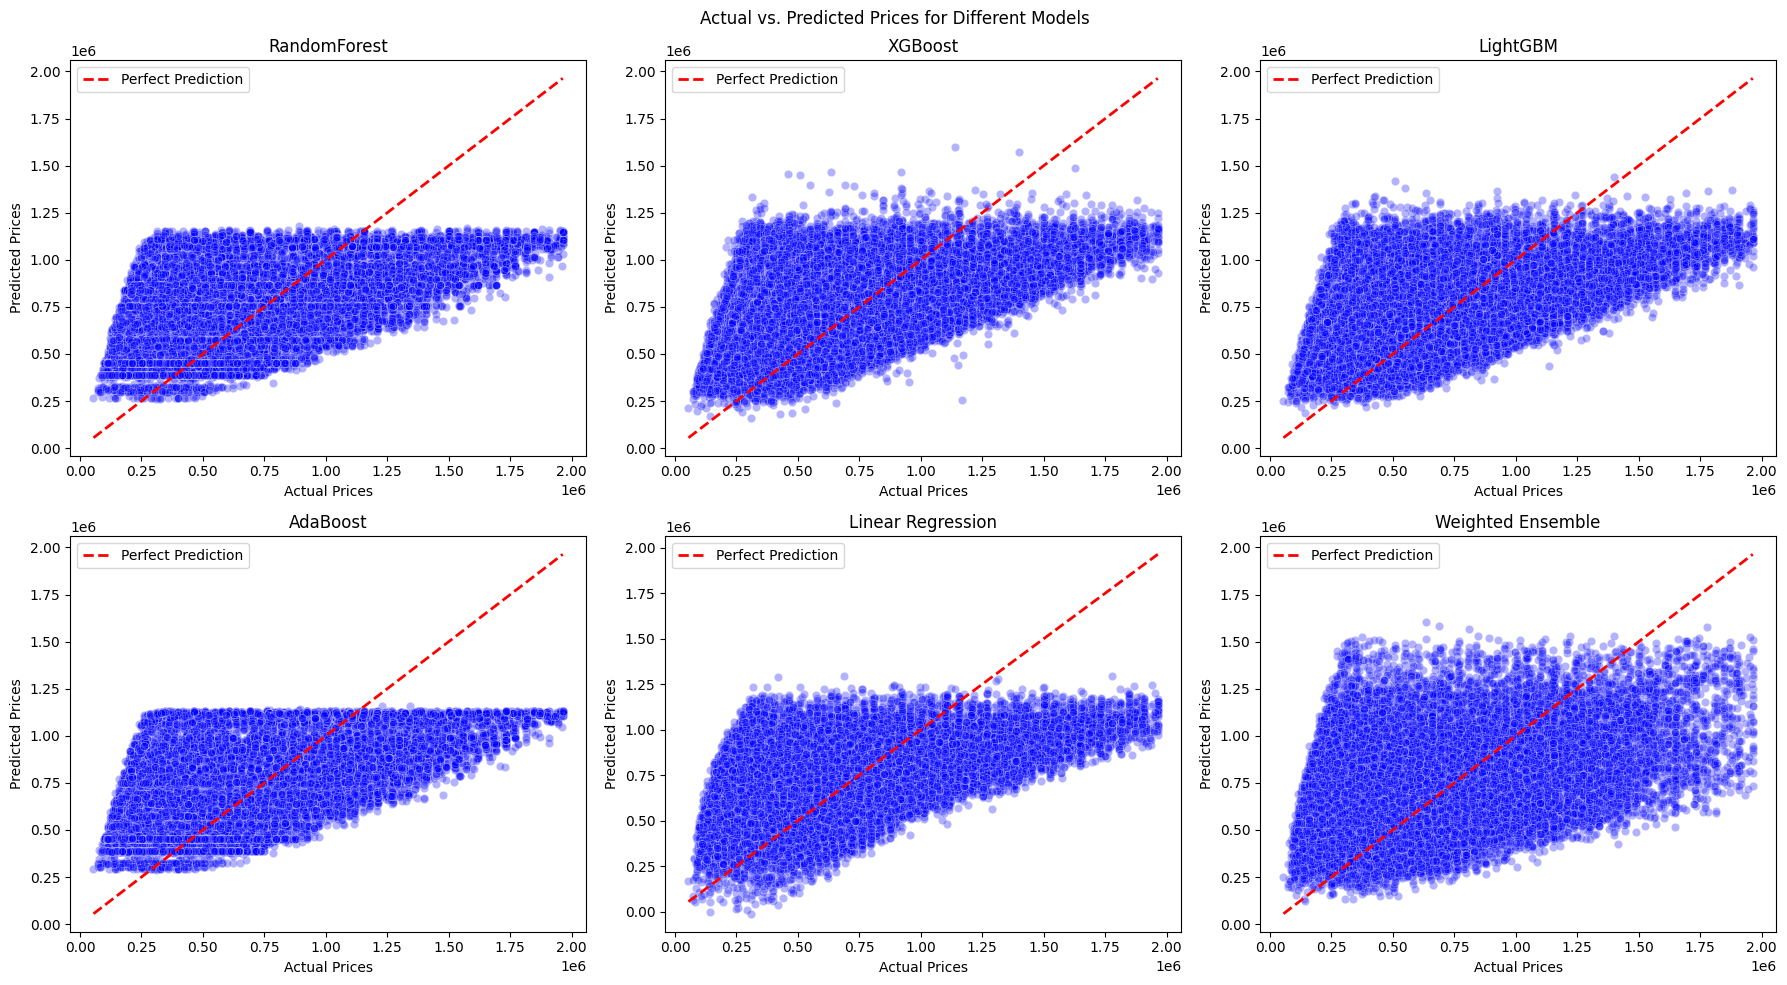

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# model predictions
model_preds = {
    'RandomForest': rf_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred,
    'AdaBoost': ada_pred,
    'Linear Regression': lr_pred,
    'Weighted Ensemble': ensemble_predictions
}

# number of subplots
num_models = len(model_preds)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 6, num_rows * 5))
plt.suptitle('Actual vs. Predicted Prices for Different Models')

i = 1
for model_name, predictions in model_preds.items():
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(x=y_test, y=predictions, alpha=0.3, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name}')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

### 3 different manual input car dataset

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


target = 'price'
features = ['car_age', 'year', 'kilometers', 'owner', 'accidental', 'transmission', 'fuel_type','car_type']

X = df[features]
y = df[target]


categorical_features = [3, 4, 5, 6,7]  # indexes of categorical columns

feature_weights = [1, 1, 3, 1, 1, 2, 2,3]  # kilometers gets 3x weight

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.07,
    depth=8,
    loss_function='RMSE',
    feature_weights=feature_weights,
    random_seed=42,
    verbose=False
)

model.fit(X_train, y_train, cat_features=categorical_features)

pred = model.predict(X_test)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

current_year = 2025

# Nexon
new_car_df_with_score_Nexon = pd.DataFrame({
    'brand': ['Tata'],
    'model_name': ['Nexon'],
    'model_variant': ['Nexon'],
    'car_type': ['SUV'],
    'transmission': ['Manual'],
    'fuel_type': ['Petrol'],
    'year': [2017],
    'kilometers': [115000.0],
    'owner': ['1st'],
    'state': ['Karnataka'],
    'accidental': ['No']
})

# Alto
new_car_df_with_score_ALTO = pd.DataFrame({
    'brand': ['Maruti Suzuki'],
    'model_name': ['Alto'],
    'model_variant': ['Z'],
    'car_type': ['Hatchback'],
    'transmission': ['Manual'],
    'fuel_type': ['Petrol'],
    'year': [2007],
    'kilometers': [115000.0],
    'owner': ['1st'],
    'state': ['Karnataka'],
    'accidental': ['No']
})

# i10
new_car_df_with_score_i10 = pd.DataFrame({
    'brand': ['Hyundai'],
    'model_name': ['i10'],
    'model_variant': ['Sportz'],
    'car_type': ['Hatchback'],
    'transmission': ['Manual'],
    'fuel_type': ['Petrol'],
    'year': [2011],
    'kilometers': [90000.0],
    'owner': ['2nd'],
    'state': ['Karnataka'],
    'accidental': ['No']
})

# Combine all
combined_cars_df = pd.concat([
    new_car_df_with_score_Nexon,
    new_car_df_with_score_ALTO,
    new_car_df_with_score_i10
], ignore_index=True)


combined_cars_df['car_age'] = current_year - combined_cars_df['year']


X_new = combined_cars_df[features]


combined_cars_df['predicted_price'] = model.predict(X_new)

combined_cars_df[['brand', 'model_name', 'model_variant', 'year', 'kilometers', 'car_age', 'predicted_price']]

R² Score (CatBoost): 0.280
MAE: 291985.90
RMSE: 352673.15


,brand,model_name,model_variant,year,kilometers,car_age,predicted_price
0,Tata,Nexon,Nexon,2017,115000.0,8,677590.165422
1,Maruti Suzuki,Alto,Z,2007,115000.0,18,511980.665323
2,Hyundai,i10,Sportz,2011,90000.0,14,521226.727785


### Saving the Models for Streamlit Dashboard

In [ ]:
import joblib
import pickle

# Save models
joblib.dump(lr_model, "../../ml_models/linearRegression_model.joblib")
joblib.dump(rf_model, "../../ml_models/randomForest_model.joblib")
joblib.dump(xgb_model, "../../ml_models/xgboost_model.joblib")
joblib.dump(ada_model, "../../ml_models/ada_model.joblib")
joblib.dump(lgbm_model, "l../../ml_models/gbm_model.joblib")
joblib.dump(dt_model, "../../ml_models/dt_model.joblib")


# Save preprocessor
joblib.dump(preprocessor, "../../ml_models/preprocessor.joblib")

# Save feature info (pickle is fine)
import pickle
feature_info = {
    "categorical": cat_features.tolist(),
    "numerical": num_features.tolist()
}
with open("../../ml_models/feature_info.pkl", "wb") as f:
    pickle.dump(feature_info, f)

# Conclusion

> All models showed relatively low predictive power, with XGBoost performing best (R² ≈ 0.293, MAE ≈ ₹2.88L, RMSE ≈ ₹3.49L). Tree-based models like RandomForest and LightGBM were close behind, while DecisionTree severely underperformed (negative R²), indicating poor generalization. Overall, results suggest the need for better feature engineering and hyperparameter tuning to improve accuracy.